# Training a Convnet from Scratch on a Small Dataset

This notebook provides lecture notes on training a convolutional neural network (ConvNet) from scratch when you have a limited amount of data.

## The relevance of deep learning for small-data problems

Deep learning models, especially ConvNets, have achieved remarkable success in image classification tasks. While they typically require large datasets for optimal performance, they can still be effective on smaller datasets through techniques like data augmentation and transfer learning (which we won't cover in detail here).

Even with small datasets, deep learning can often outperform traditional machine learning methods on complex image tasks by automatically learning hierarchical features directly from the data.

## Downloading the data

For this lecture, we will use a small image dataset available in scikit-learn.

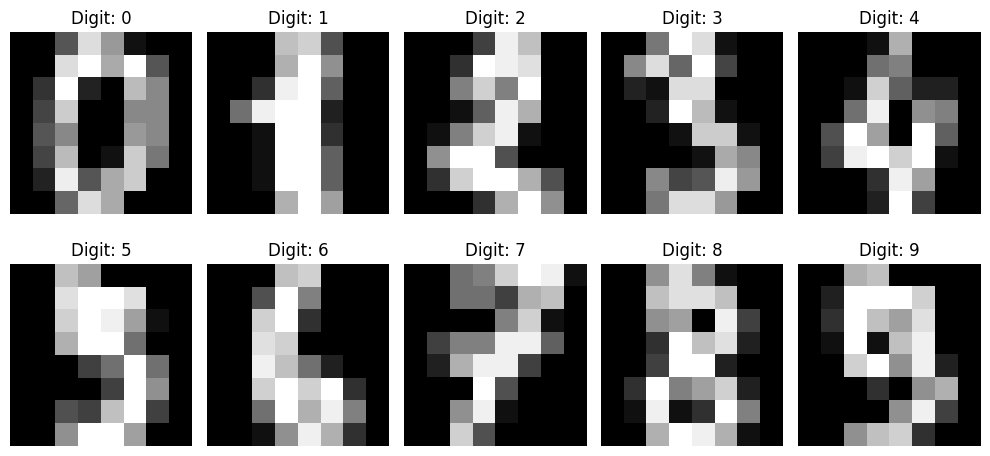

Number of samples: 1797
Image shape: (8, 8)


In [ ]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# Load the digits dataset
digits = load_digits()

# Display some sample images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f'Digit: {digits.target[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

print(f"Number of samples: {len(digits.images)}")
print(f"Image shape: {digits.images[0].shape}")

## Building your network

We will build a simple ConvNet model using Keras.

- **Convolutional Layers:** These layers apply filters to the input image to detect features like edges, corners, and textures.  
The output of a convolutional layer is a feature map.

  Mathematically, a convolution operation can be represented as:

<center>

$(I * K)(i, j) = \sum_m \sum_n I(i - m, j - n) K(m, n)$

</center>

   where *I* is the input image, *K* is the convolution kernel (filter), and *(i, j)* are the coordinates in the output feature map.



- **Pooling Layers:** These layers reduce the spatial dimensions (width and height) of the feature maps, which helps reduce the number of parameters and computational cost, and makes the network more robust to small shifts in the input.  
Max pooling is a common type, where the maximum value within a window is taken.


- **Activation Functions:** Non-linear functions (like ReLU) are applied after convolutional layers to introduce non-linearity into the model, allowing it to learn more complex patterns.  

     ReLU function:  $f(x) = \max(0, x)$



- **Flatten Layer:** This layer flattens the 2D feature maps into a 1D vector.

- **Dense Layers:** These are fully connected layers that perform classification based on the features extracted by the convolutional and pooling layers.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(8, 8, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax') # 10 classes for digits 0-9
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 6, 6, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,466 (76.04 KB)

 Trainable params: 19,466 (76.04 KB)

 Non-trainable params: 0 (0.00 B)

## Data preprocessing

Before training, we need to preprocess the data:

*   **Reshaping:** ConvNets expect input in the shape of (height, width, channels). Our images are 8x8, and since they are grayscale, they have 1 channel.
*   **Normalization:** Pixel values are typically scaled to a range between 0 and 1.

In [ ]:
import numpy as np

# Reshape images to include the channel dimension
X = digits.images.reshape(-1, 8, 8, 1)
y = digits.target

# Normalize pixel values
X = X.astype('float32') / 15.0 # Max pixel value is 15

# Split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (1437, 8, 8, 1)
Testing data shape: (360, 8, 8, 1)


## Using data augmentation

Data augmentation is a crucial technique for training deep learning models on small datasets. It involves creating new training examples by applying random transformations to the existing images, such as:

*   Rotation
*   Zooming
*   Shifting
*   Flipping

This helps to increase the size and diversity of the training data, making the model more robust and less prone to overfitting.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images by up to 10 degrees
    zoom_range=0.1,     # randomly zoom images by up to 10%
    width_shift_range=0.1, # randomly shift images horizontally by up to 10%
    height_shift_range=0.1 # randomly shift images vertically by up to 10%
)

# Fit the generator on the training data
datagen.fit(X_train)

# Now you can use the generator during training
# model.fit(datagen.flow(X_train, y_train, batch_size=32), ...)

## Conclusion

In this notebook, we explored how to train a ConvNet from scratch on a small dataset. We used the scikit-learn digits dataset, which is a good example of a small image dataset. We built a simple ConvNet model using Keras, preprocessed the data by reshaping and normalizing it, and used data augmentation to increase the size and diversity of the training data. These techniques are essential for achieving good performance when training deep learning models on limited data.